In [2]:
!pip install econml

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 3.5 MB 2.5 MB/s eta 0:00:01
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/26/21/c796aaef2e9c805ea2e608893a67ff88395ded66788122959ac710ad4d6e/sparse-0.13.0-py2.py3-none-any.whl (77 kB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/c4/e0/c1480994d39eaa66faa7d4106a4daea7b345dcc31ad83196460c2676701c/dowhy-0.6-py3-none-any.whl (123 kB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/a1/00/84c572ff02b27dd828d6095158f4bda576c124c4c863be7bf14f58101e53/lightgbm-3.3.2-py3-none-manylinux1_x86_64.whl (2.0 MB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/b9/f4/c5b95cddae15be80f8e58b25edceca105aa83c0b8c86a1edad24a6af80d3/shap-0.39.0.tar.gz (356 kB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/ea/76/75b1bb82e9bad3e3d656556eaa353d8cd17c4254393b08ec9786ac8ed273/pydot-

In [3]:
# Some imports to get us started
# Utilities
import os
import urllib.request
import numpy as np
import pandas as pd

# Generic ML imports
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import (Lasso, LassoCV, LogisticRegression,
                                  LogisticRegressionCV,LinearRegression,
                                  MultiTaskElasticNet,MultiTaskElasticNetCV)
# EconML imports
from econml.dml import LinearDML, CausalForestDML, SparseLinearDML
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter

import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image,display

import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures

import dowhy
from dowhy import CausalModel

from econml.iv.dr import LinearIntentToTreatDRIV

In [5]:
from sklearn.preprocessing import StandardScaler

In [2]:
data=pd.read_csv('/content/fhvhvmerge.csv')

NameError: name 'pd' is not defined

# 新段落

In [ ]:
data.isnull().sum().sort_values(ascending=False)

Zone            0
Borough         0
T               0
last_stage      0
X               0
stage           0
Y               0
PULocationID    0
dtype: int64

In [ ]:
data.head()

,PULocationID,Y,stage,X,last_stage,T,Borough,Zone
0,61,4965.571429,1,9368.099768,0,640,Brooklyn,Crown Heights North
1,61,3257.700000,2,4965.571429,1,6360,Brooklyn,Crown Heights North
2,61,2984.250000,3,3257.700000,2,9379,Brooklyn,Crown Heights North
3,61,4082.789474,4,2984.250000,3,3556,Brooklyn,Crown Heights North
4,61,5283.000000,5,4082.789474,4,888,Brooklyn,Crown Heights North


In [ ]:
len(data)

In [ ]:
data.drop(['Borough'],axis=1,inplace=True)

In [ ]:
#data['X']=StandardScaler().fit_transform(data['X'].values.reshape(-1,1))

In [ ]:
data.head()

,PULocationID,Y,stage,X,last_stage,T,Zone
0,61,4965.571429,1,9368.099768,0,640,Crown Heights North
1,61,3257.700000,2,4965.571429,1,6360,Crown Heights North
2,61,2984.250000,3,3257.700000,2,9379,Crown Heights North
3,61,4082.789474,4,2984.250000,3,3556,Crown Heights North
4,61,5283.000000,5,4082.789474,4,888,Crown Heights North


In [ ]:
# Define estimator inputs
Y = data["Y"]  # outcome of interest
T = data["T"]  # intervention, or treatment
X = data[["X"]]  # features
W = data.drop(columns=["Y", "X", "T","Zone","last_stage"])  # confounders混杂因素,通过后门调整去掉了
print(type(X))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
X.describe()

,X
count,2074.000000
mean,1117.741045
std,1270.316828
min,0.000000
25%,312.960526
50%,744.657895
75%,1478.582339
max,12766.097150


In [ ]:
# Get test data---不太确定这里要怎么定义X_test_data(待确定1)
X_test_data =X.iloc[:200]

In [ ]:
#定义真实的treatment effect function-------（待确定2)
TE_fn=lambda X:X['X']
true_TE=TE_fn(X_test_data)

In [ ]:
true_TE

0      9368.099768
1      4965.571429
2      3257.700000
3      2984.250000
4      4082.789474
          ...     
195     408.500000
196     633.473684
197     912.900000
198    1201.100000
199    1465.300000
Name: X, Length: 200, dtype: float64

In [ ]:
feature_names = W.columns.tolist()
print(feature_names)

['PULocationID', 'stage']


In [ ]:
#定义模型
est_Lin = LinearDML(
    model_y=GradientBoostingRegressor(),
    model_t=GradientBoostingRegressor(),
    featurizer=PolynomialFeatures(degree=2, include_bias=False),
)
# fit through dowhy
est_Lin = est_Lin.dowhy.fit(Y, T, X=X, W=W, outcome_names=["demand"], treatment_names=["policy"], feature_names=["X"],
               confounder_names=feature_names, inference="statsmodels")

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


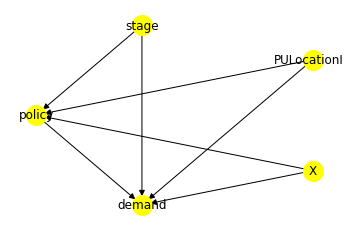

In [ ]:
# 对因果图（causal graph）进行可视化
try:
    # 通过pydot和pygraphviz进行可视化
    display(
        Image(to_pydot(est_dw._graph._graph).create_png())
    )
except:
	# 使用默认方式进行可视化
    est_Lin.view_model()

In [ ]:
#识别estimator
identified_estimand = est_Lin.identified_estimand_
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                              
─────────(Expectation(demand|stage,PULocationID,X))
d[policy]                                          
Estimand assumption 1, Unconfoundedness: If U→{policy} and U→demand then P(demand|policy,stage,PULocationID,X,U) = P(demand|policy,stage,PULocationID,X)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [ ]:
#估计
lineardml_estimate=est_Lin.estimate_
print(lineardml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                              
─────────(Expectation(demand|stage,PULocationID,X))
d[policy]                                          
Estimand assumption 1, Unconfoundedness: If U→{policy} and U→demand then P(demand|policy,stage,PULocationID,X,U) = P(demand|policy,stage,PULocationID,X)

## Realized estimand
b: demand~policy+stage+PULocationID+X | X
Target units: ate

## Estimate
Mean value: -27.119680422289033
Effect estimates: [-1468.46383074  -398.28820634  -159.62647087 ...    22.03447011
    22.03544018    22.03544018]



In [ ]:
true_x_TE = TE_fn(X_test_data)
print("True ATE on test data: ", true_x_TE.mean())

True ATE on test data:  1.330158960868728


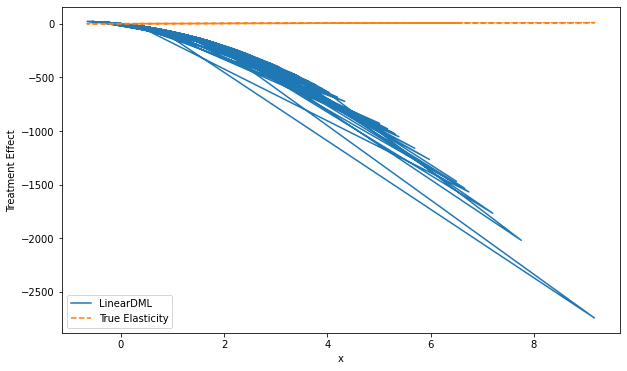

In [ ]:
# Get treatment effect and its confidence interval
te_pred = est_Lin.effect(X_test_data)
te_pred_interval = est_Lin.effect_interval(X_test_data)
# Compare the estimate and the truth
plt.figure(figsize=(10, 6))
plt.plot(X_test_data, te_pred, label="LinearDML")
plt.plot(X_test_data, true_x_TE, "--", label="True Elasticity")
plt.xlabel("x")
plt.ylabel("Treatment Effect")
plt.legend()

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names


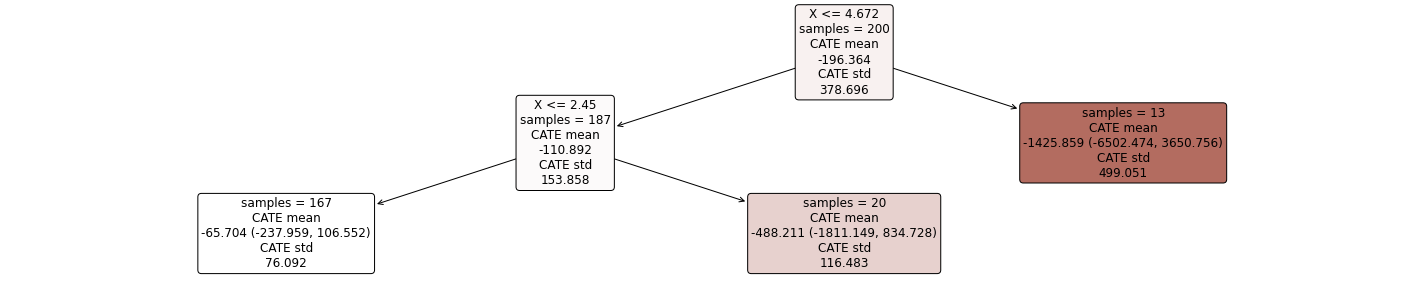

In [ ]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)
intrp.interpret(est_Lin, X_test_data)
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=X.columns, fontsize=12)

In [ ]:
#定义模型
# est_Forest = CausalForestDML(
#     model_y=GradientBoostingRegressor(),
#     model_t=GradientBoostingRegressor(),
#     featurizer=PolynomialFeatures(degree=2, include_bias=False)
# )
est_Forest = CausalForestDML(
    model_y=GradientBoostingRegressor(),
    model_t=GradientBoostingRegressor(),
    featurizer=PolynomialFeatures(degree=4, include_bias=True),
    random_state=123
  )

# fit through dowhy
# est_Forest = est_Forest.dowhy.fit(Y, T, X=X, W=W, outcome_names=["demand"], treatment_names=["policy"], feature_names=["X"],
#                confounder_names=feature_names)
est_Forest = est_Forest.dowhy.fit(Y, T, X=X, W=W, outcome_names=["demand"], treatment_names=["policy"], feature_names=["X"],
                confounder_names=feature_names)

print('score:',est_Forest.score)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


score: <bound method _RLearner.score of <econml.dml.causal_forest.CausalForestDML object at 0x7fdca5be07d0>>


[-4539.91516219 -1851.97763631  -443.72084975 ...    18.53346482
    18.53346482    18.53346482]


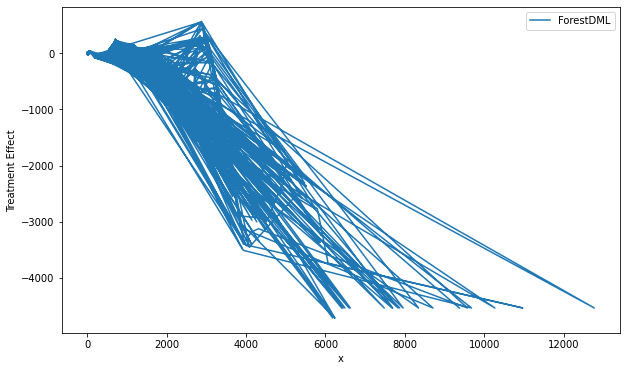

In [ ]:
point = est_Forest.effect(X)
lb, ub = est_Forest.effect_interval(X, alpha=0.05)

print(point)
plt.figure(figsize=(10, 6))
plt.plot(X, point, label="ForestDML")
#plt.plot(X_test_data, true_x_TE, "--", label="True Elasticity")
#plt.plot(X, lb, "--", label="effect_interval")
plt.xlabel("x")
plt.ylabel("Treatment Effect")
plt.legend()

[[-4539.91516219]
 [-1851.97763631]
 [ -443.72084975]
 ...
 [   18.53346482]
 [   18.53346482]
 [   18.53346482]]
<class 'numpy.ndarray'>
                X
0     9368.099768
1     4965.571429
2     3257.700000
3     2984.250000
4     4082.789474
...           ...
2069     1.100000
2070     1.100000
2071     1.400000
2072     0.000000
2073     0.000000

[2074 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>


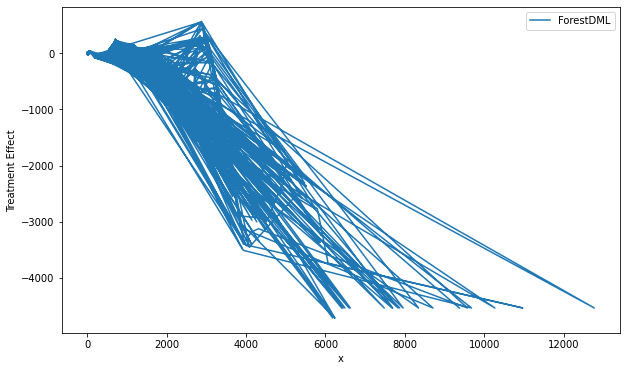

In [ ]:
ate = est_Forest.const_marginal_effect(X)

print(ate)
print(type(ate))
print(X)
print(type(X))
plt.figure(figsize=(10, 6))
plt.plot(X, ate, label="ForestDML")
#plt.plot(X_test_data, true_x_TE, "--", label="True Elasticity")
#plt.plot(X, lb, "--", label="effect_interval")
plt.xlabel("x")
plt.ylabel("Treatment Effect")
plt.legend()

In [ ]:
ate_list = ate.tolist()
X_list = X.values.tolist()

print("X_len:", len(X_list))
print("X:", X_list)

X_len: 2074
X: [[9368.099768], [4965.571429], [3257.7], [2984.25], [4082.789474], [5283.0], [5796.5], [6065.8], [10965.18274], [3986.857143], [895.9], [383.375], [493.6052632], [1054.2], [1372.3], [1531.6], [9675.245273999999], [3932.642857], [812.9], [617.75], [947.1315788999999], [1575.3], [2290.2], [2523.3], [6236.127788000001], [3887.428571], [3140.5], [2887.5], [3828.5], [4553.2], [4922.0], [5002.3], [10263.982179999999], [3388.642857], [621.0], [453.125], [703.1315789], [1091.6], [1478.1], [1852.2], [6443.719118999999], [3388.214286], [1848.7], [1647.625], [2364.315789], [3306.7], [3723.7], [3870.5], [8705.306339], [3377.0], [681.9], [521.875], [792.9736842], [1380.7], [1850.7], [2048.3], [12766.09715], [3328.285714], [557.8], [286.375], [458.3421053], [1248.1], [1532.0], [1710.1], [5904.275731000001], [3293.928571], [2379.3], [2239.75], [3081.368421], [3945.0], [4145.6], [4313.5], [9572.575998], [3205.285714], [520.9], [414.25], [650.9473684], [1083.1], [1600.1], [1897.0], [7954

In [ ]:
print(X_list[1][0])

4965.571429


In [ ]:

a = [1, 2, 3, 4]
print(a[0])
print("X_list:",X_list[0][0])

print("X_list:",X_list)
print("x_type", type(X_list))
print('ate_list:', ate_list)


ATE_Dict = {X_list[n][0]: ate_list[n][0] for n in range(len(X_list))}
print('ATE_Dict:',ATE_Dict)


1
X_list: 9368.099768
X_list: [[9368.099768], [4965.571429], [3257.7], [2984.25], [4082.789474], [5283.0], [5796.5], [6065.8], [10965.18274], [3986.857143], [895.9], [383.375], [493.6052632], [1054.2], [1372.3], [1531.6], [9675.245273999999], [3932.642857], [812.9], [617.75], [947.1315788999999], [1575.3], [2290.2], [2523.3], [6236.127788000001], [3887.428571], [3140.5], [2887.5], [3828.5], [4553.2], [4922.0], [5002.3], [10263.982179999999], [3388.642857], [621.0], [453.125], [703.1315789], [1091.6], [1478.1], [1852.2], [6443.719118999999], [3388.214286], [1848.7], [1647.625], [2364.315789], [3306.7], [3723.7], [3870.5], [8705.306339], [3377.0], [681.9], [521.875], [792.9736842], [1380.7], [1850.7], [2048.3], [12766.09715], [3328.285714], [557.8], [286.375], [458.3421053], [1248.1], [1532.0], [1710.1], [5904.275731000001], [3293.928571], [2379.3], [2239.75], [3081.368421], [3945.0], [4145.6], [4313.5], [9572.575998], [3205.285714], [520.9], [414.25], [650.9473684], [1083.1], [1600.1], 

In [ ]:
ATE_Dict.items()

dict_items([(9368.099768, -4539.915162194795), (4965.571429, -1851.9776363068704), (3257.7, -443.72084974510756), (2984.25, 318.54436241700705), (4082.789474, -3454.18423463924), (5283.0, -2515.1147049923643), (5796.5, -2770.541992456856), (6065.8, -3741.8455479975173), (10965.18274, -4539.915162194795), (3986.857143, -3413.2378413671136), (895.9, -160.74145124921884), (383.375, -106.80285420326108), (493.6052632, -50.23929319833168), (1054.2, 22.779208044721337), (1372.3, -366.29500641864905), (1531.6, -4.238554695308352), (9675.245273999999, -4539.915162194795), (3932.642857, -3511.548818929467), (812.9, 103.5970861567547), (617.75, -75.35547766982373), (947.1315788999999, 74.4232349924684), (1575.3, -395.34656797524775), (2290.2, -429.1349196434188), (2523.3, -1121.1007046912014), (6236.127788000001, -4718.050819383545), (3887.428571, -3040.9584295560126), (3140.5, -57.401771630820996), (2887.5, 510.3249389852044), (3828.5, -2898.5287357336333), (4553.2, -2944.9367631337063), (4922.

In [ ]:
#将因果效应按降序排序
ATE_Dict_descend = sorted(ATE_Dict.items(), key=lambda x: x[1], reverse = True)
print(ATE_Dict_descend)

[(2878.142857, 569.8923870053144), (2872.892236, 559.7821624845601), (2869.633996, 559.7821624845601), (2897.4, 546.652331859615), (2887.5, 510.3249389852044), (2899.785714, 445.9250153834819), (2900.142857, 440.06754514706677), (2838.1, 319.53463237707376), (2984.25, 318.54436241700705), (2956.2, 312.2067291236037), (3001.4, 294.8742753093944), (3024.686275, 294.3640587623517), (3036.142857, 287.92964760659424), (3014.7, 286.86410485081), (2830.823059, 278.10042821715217), (2831.9397649999996, 278.10042821715217), (3014.590382, 267.64905892158885), (3026.457709, 259.5417224269871), (713.7, 255.19718714103658), (713.6, 255.19718714103658), (716.6, 251.6090422453838), (2799.5, 251.3942807216024), (730.0, 245.67332639929245), (729.0789474, 245.53573653663855), (726.6702315, 242.36033554739072), (717.2, 240.15560573989694), (723.6125165, 238.90513683607304), (724.7, 238.36020148779883), (726.0, 237.1122226823878), (721.9736842, 236.38696249164647), (721.9285714, 236.38696249164647), (723.

In [ ]:


type(ATE_Dict_descend[1][0])

float

In [ ]:
for i in range(len(ATE_Dict_descend)):
  print('第',i+1,'行','所属阶段',data[data['X'].isin([ATE_Dict_descend[i][0]])]['stage'])
  print('所属地区',data[data['X'].isin([ATE_Dict_descend[i][0]])]['Zone'])
  print('----------------------------------')


第 1 行 所属阶段 113    2
Name: stage, dtype: int64
所属地区 113    Bedford
Name: Zone, dtype: object
----------------------------------
第 2 行 所属阶段 544    1
Name: stage, dtype: int64
所属地区 544    Melrose South
Name: Zone, dtype: object
----------------------------------
第 3 行 所属阶段 1064    1
Name: stage, dtype: int64
所属地区 1064    Hudson Sq
Name: Zone, dtype: object
----------------------------------
第 4 行 所属阶段 173    6
Name: stage, dtype: int64
所属地区 173    Prospect-Lefferts Gardens
Name: Zone, dtype: object
----------------------------------
第 5 行 所属阶段 27    4
Name: stage, dtype: int64
所属地区 27    East New York
Name: Zone, dtype: object
----------------------------------
第 6 行 所属阶段 105    2
Name: stage, dtype: int64
所属地区 105    Flatbush/Ditmas Park
Name: Zone, dtype: object
----------------------------------
第 7 行 所属阶段 97    2
Name: stage, dtype: int64
所属地区 97    Times Sq/Theatre District
Name: Zone, dtype: object
----------------------------------
第 8 行 所属阶段 126    7
Name: stage, dtype: int64
所属地区

KeyboardInterrupt: ignored

In [ ]:
print(data[data['X'].isin([2878.142857])])

     PULocationID       Y  stage            X  last_stage     T     Zone
113            17  1671.6      2  2878.142857           1  6360  Bedford


In [ ]:
from econml.dynamic.dml import DynamicDML

In [ ]:
from econml.dynamic.dml import DynamicDML

np.random.seed(123)

n_panels = 100  # number of panels
n_periods = 3  # number of time periods per panel
n = n_panels * n_periods
groups = np.repeat(a=np.arange(n_panels), repeats=n_periods, axis=0)
X = np.random.normal(size=(n, 1))
T = np.random.normal(size=(n, 2))
y = np.random.normal(size=(n, ))
est = DynamicDML()
est.fit(y, T, X=X, W=None, groups=groups, inference="auto")

'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please

In [ ]:
est.const_marginal_effect(X[:2])

array([[-0.33649377, -0.04879177, -0.06100945,  0.04287695, -0.20427584,
         0.00667271],
       [-0.10143508,  0.43307505,  0.05471369, -0.21757857, -0.10151656,
        -0.15925468]])

In [ ]:
 type(point)
 print(len(point))

2074


Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names


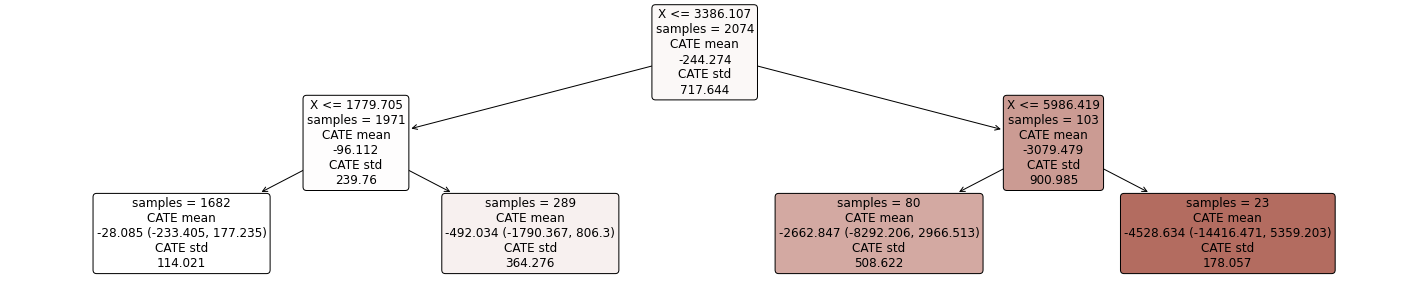

In [ ]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)
intrp.interpret(est_Forest, X)
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=X.columns, fontsize=12)

In [ ]:
data.head()

,PULocationID,Y,stage,X,last_stage,T,Zone
0,61,4965.571429,1,6.496292,0,640,Crown Heights North
1,61,3257.700000,2,3.029763,1,6360,Crown Heights North
2,61,2984.250000,3,1.684993,2,9379,Crown Heights North
3,61,4082.789474,4,1.469680,3,3556,Crown Heights North
4,61,5283.000000,5,2.334664,4,888,Crown Heights North


In [ ]:
data_X = data['X'] <= 2.359
data_X

0       False
1       False
2        True
3        True
4        True
        ...  
2069     True
2070     True
2071     True
2072     True
2073     True
Name: X, Length: 2074, dtype: bool

In [ ]:
# Add Random Common Cause 
res_random = est_Forest.refute_estimate(method_name="random_common_cause")
print(res_random)

# Add Unobserved Common Cause 
res_unobserved = est_Forest.refute_estimate(
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="linear",
    confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.1,
    effect_strength_on_outcome=0.1,
)
print(res_unobserved)

#Replace Treatment with a Random (Placebo) Variable
res_placebo = est_Forest.refute_estimate(
    method_name="placebo_treatment_refuter", placebo_type="permute", 
    num_simulations=3
)
print(res_placebo)
# Remove a Random Subset of the Data
res_subset = est_Forest.refute_estimate(
    method_name="data_subset_refuter", subset_fraction=0.8, 
    num_simulations=3)
print(res_subset)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Refute: Add a Random Common Cause
Estimated effect:-244.27379742604566
New effect:-242.73413437035182



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Refute: Add an Unobserved Common Cause
Estimated effect:-244.27379742604566
New effect:-17.520310467410727



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Refute: Use a Placebo Treatment
Estimated effect:-244.27379742604566
New effect:0.0008997658759083805
p value:0.24286809487014327



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Refute: Use a subset of data
Estimated effect:-244.27379742604566
New effect:-61.271942636038034
p value:0.0005564622737820385



In [ ]:
#定义模型
# est_Forest = CausalForestDML(
#     model_y=GradientBoostingRegressor(),
#     model_t=GradientBoostingRegressor(),
#     featurizer=PolynomialFeatures(degree=2, include_bias=False)
# )
est_Sparse = SparseLinearDML(
    model_y=GradientBoostingRegressor(),
    model_t=GradientBoostingRegressor(),
    featurizer=PolynomialFeatures(degree=4, include_bias=True)
    
  )

# fit through dowhy
# est_Forest = est_Forest.dowhy.fit(Y, T, X=X, W=W, outcome_names=["demand"], treatment_names=["policy"], feature_names=["X"],
#                confounder_names=feature_names)
est_Sparse = est_Sparse.dowhy.fit(Y, T, X=X, W=W, outcome_names=["demand"], treatment_names=["policy"], feature_names=["X"],
                confounder_names=feature_names)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its defa

[-18681.7104501   -2952.07092755   -835.39105383 ...    -32.95169177
    -32.97370023    -32.97370023]


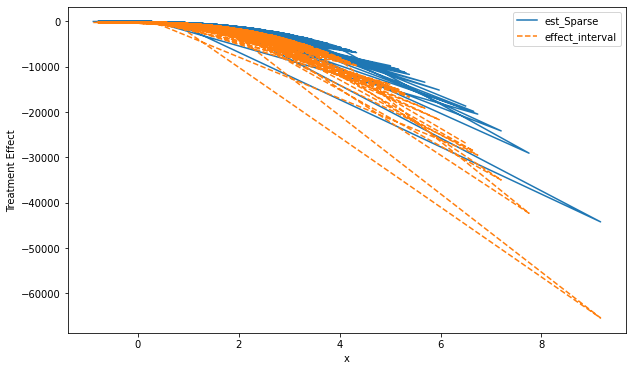

In [ ]:
point = est_Sparse.effect(X)
lb, ub = est_Sparse.effect_interval(X, alpha=0.05)

print(point)
plt.figure(figsize=(10, 6))
plt.plot(X, point, label="est_Sparse")
#plt.plot(X_test_data, true_x_TE, "--", label="True Elasticity")
plt.plot(X, lb, "--", label="effect_interval")
plt.xlabel("x")
plt.ylabel("Treatment Effect")
plt.legend()

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names


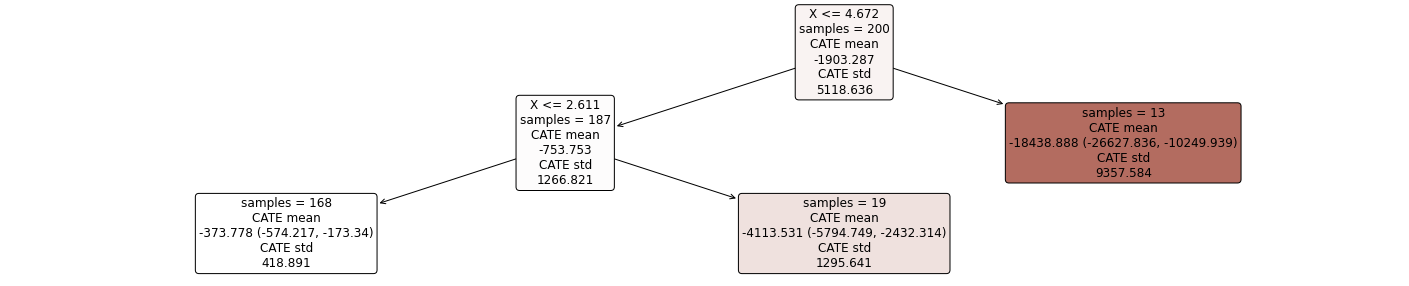

In [ ]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)
intrp.interpret(est_Sparse, X_test_data)
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=X.columns, fontsize=12)

In [ ]:
# Add Random Common Cause 
res_random = est_Sparse.refute_estimate(method_name="random_common_cause")
print(res_random)

# Add Unobserved Common Cause 
res_unobserved = est_Sparse.refute_estimate(
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="linear",
    confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.1,
    effect_strength_on_outcome=0.1,
)
print(res_unobserved)

#Replace Treatment with a Random (Placebo) Variable
res_placebo = est_Sparse.refute_estimate(
    method_name="placebo_treatment_refuter", placebo_type="permute", 
    num_simulations=3
)
print(res_placebo)
# Remove a Random Subset of the Data
res_subset = est_Sparse.refute_estimate(
    method_name="data_subset_refuter", subset_fraction=0.8, 
    num_simulations=3)
print(res_subset)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its defa

Refute: Add a Random Common Cause
Estimated effect:-318.90769240058677
New effect:-223.36509072790943



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed 

Refute: Add an Unobserved Common Cause
Estimated effect:-318.90769240058677
New effect:65.89495620124397



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed 

Refute: Use a Placebo Treatment
Estimated effect:-318.90769240058677
New effect:-0.0002906043107018165
p value:0.4716319680875598



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed 

Refute: Use a subset of data
Estimated effect:-318.90769240058677
New effect:-66.11187070349202
p value:0.038948246922363726



'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please

In [3]:
import os
import pandas as pd
import urllib.request
# Import the data
file_name = "oj_large.csv"

if not os.path.isfile(file_name):
    print("Downloading file (this might take a few seconds)...")
    urllib.request.urlretrieve("https://msalicedatapublic.blob.core.windows.net/datasets/OrangeJuice/oj_large.csv", file_name)
oj_data = pd.read_csv(file_name)